# MSA 2023 Phase 2 - Part 1


In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression,SelectKBest
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

RANDOM_STATE = 101
%matplotlib inline

## 1. Find all variables and understand them


### Data salaries


#### load data


In [2]:
df_salaries = pd.read_csv('../0. Resources/datasets/data_salaries.csv')
print(df_salaries.shape)
df_salaries.head(10)

(3755, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
5,2023,SE,FT,Applied Scientist,222200,USD,222200,US,0,US,L
6,2023,SE,FT,Applied Scientist,136000,USD,136000,US,0,US,L
7,2023,SE,FT,Data Scientist,219000,USD,219000,CA,0,CA,M
8,2023,SE,FT,Data Scientist,141000,USD,141000,CA,0,CA,M
9,2023,SE,FT,Data Scientist,147100,USD,147100,US,0,US,M


#### explore data


In [3]:
df_salaries.nunique()

work_year                4
experience_level         4
employment_type          4
job_title               93
salary                 815
salary_currency         20
salary_in_usd         1035
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

In [4]:
df_salaries.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [5]:
df_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [6]:
numerical_cols = ['salary', 'salary_in_usd', 'remote_ratio']
print(f'mean:\n{df_salaries[numerical_cols].mean()}\n')
print(f'std:\n{df_salaries[numerical_cols].std()}')

mean:
salary           190695.571771
salary_in_usd    137570.389880
remote_ratio         46.271638
dtype: float64

std:
salary           671676.500508
salary_in_usd     63055.625278
remote_ratio         48.589050
dtype: float64


#### data visualization


[Text(0.5, 1.0, 'Distribution of the salary in usd')]

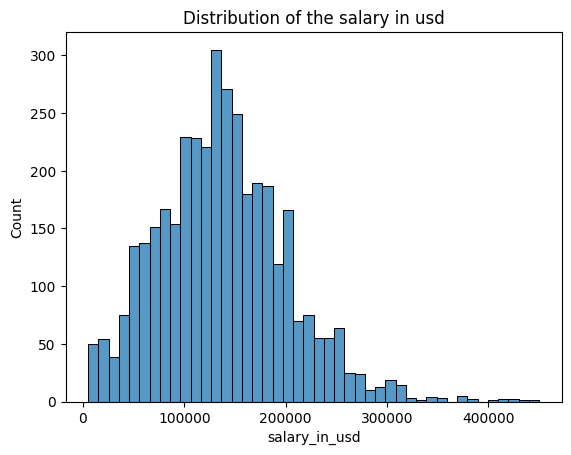

In [7]:
ax = sns.histplot(data=df_salaries, x='salary_in_usd')
ax.set(title='Distribution of the salary in usd')

[Text(0, 0.5, 'num_people'),
 Text(0.5, 1.0, 'Number of people by Experience Level')]

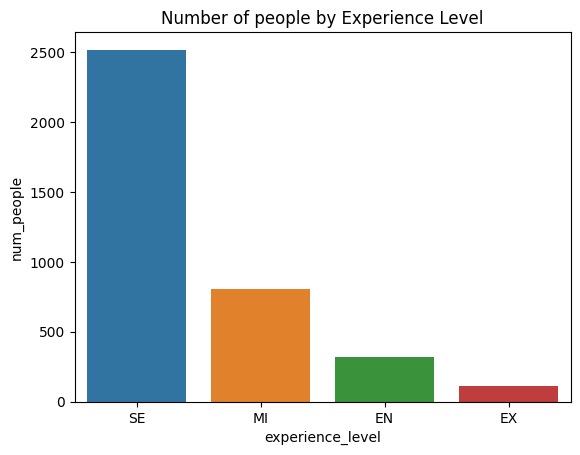

In [8]:
experience_counts = df_salaries['experience_level'].value_counts()
ax = sns.barplot(data=df_salaries, x=experience_counts.index,
                 y=experience_counts.values)
ax.set(ylabel='num_people', title='Number of people by Experience Level')

[Text(0.5, 1.0, 'Salary (in USD) by Experience Level')]

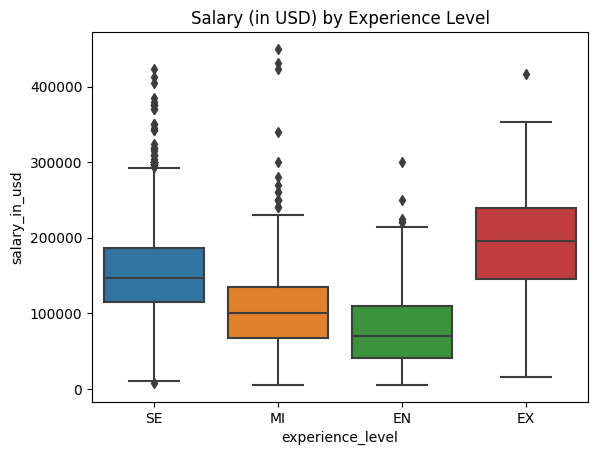

In [9]:
ax = sns.boxplot(data=df_salaries, x='experience_level', y='salary_in_usd')
ax.set(title='Salary (in USD) by Experience Level')

[Text(0.5, 1.0, 'Salary (in USD) by Company Size')]

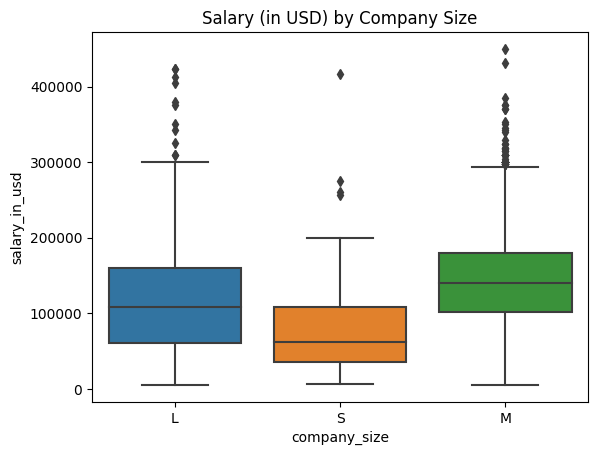

In [10]:
ax = sns.boxplot(data=df_salaries, x='company_size', y='salary_in_usd')
ax.set(title='Salary (in USD) by Company Size')

#### clean data


##### check missing values


In [11]:
df_salaries.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

no missing values found


##### check duplicated values


found the duplicated data and drop it


In [12]:
df_salaries.duplicated().sum()

1171

In [13]:
df_salaries_clean = df_salaries.drop_duplicates()
df_salaries_clean = df_salaries_clean.reset_index(drop=True)
df_salaries_clean.shape

(2584, 11)

##### drop the columns


drop the salary and salary_currency columns as we already have the salary in usd that is match all the currency


In [14]:
df_salaries_clean = df_salaries_clean.drop(
    columns=['salary', 'salary_currency'])
df_salaries_clean.shape

(2584, 9)

##### outlier detection


<Axes: >

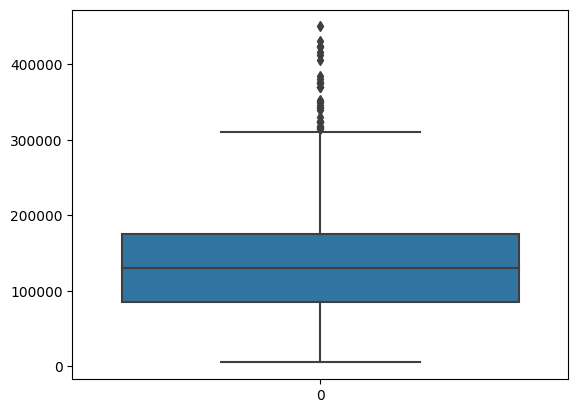

In [15]:
sns.boxplot(df_salaries_clean['salary_in_usd'])

Due to the possibility that these outliers could represent legitimate high salaries in this context, it may not be appropriate to remove them. We might find it useful to explore them further. For example, we might examine whether the high salaries are related to particular job titles, experience levels, or company sizes. This could provide us with valuable insights into what drives these high salaries.


In [16]:
def iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    threshold = 1.5 * IQR
    lower_bound = Q1 - threshold
    upper_bound = Q3 + threshold
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]


# Check for outliers in the salary_in_usd column
salary_outliers = iqr_outliers(df_salaries_clean, 'salary_in_usd')

# Display the outliers
salary_outliers

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
33,2023,SE,FT,Computer Vision Engineer,342810,US,0,US,M
131,2023,SE,FT,Machine Learning Engineer,342300,US,0,US,L
143,2023,SE,FT,Machine Learning Engineer,318300,US,100,US,M
207,2023,EX,FT,Head of Data,329500,US,0,US,M
392,2023,EX,FT,Director of Data Science,353200,US,0,US,M
400,2023,SE,FT,Data Scientist,317070,US,0,US,M
427,2023,SE,FT,AI Scientist,423834,IL,0,IL,L
512,2023,SE,FT,Data Architect,376080,US,100,US,M
645,2023,MI,FT,Research Scientist,340000,US,100,US,M
785,2023,SE,FT,Data Scientist,370000,US,0,US,M


##### transform category to numerical


In [17]:

category_columns = ['experience_level', 'employment_type', 'job_title',
                    'employee_residence', 'company_location', 'company_size']
le = LabelEncoder()
df_salaries_clean[category_columns] = df_salaries_clean[category_columns].apply(
    le.fit_transform)
df_salaries_clean

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,3,2,84,85847,26,100,25,0
1,2023,2,0,66,30000,75,100,70,2
2,2023,2,0,66,25500,75,100,70,2
3,2023,3,2,47,175000,11,100,12,1
4,2023,3,2,47,120000,11,100,12,1
...,...,...,...,...,...,...,...,...,...
2579,2020,3,2,47,412000,75,100,70,0
2580,2021,2,2,84,151000,75,100,70,0
2581,2020,0,2,47,105000,75,100,70,2
2582,2020,0,0,17,100000,75,100,70,0


##### get the correlation score for features


According to the table below, the company size plays a very minimal role in the salary in US dollars (only **0.0022** correlation). Also, the employment type and remote ratio play very minor roles (**-0.041** and **-0,085**).


<Figure size 1500x1500 with 0 Axes>

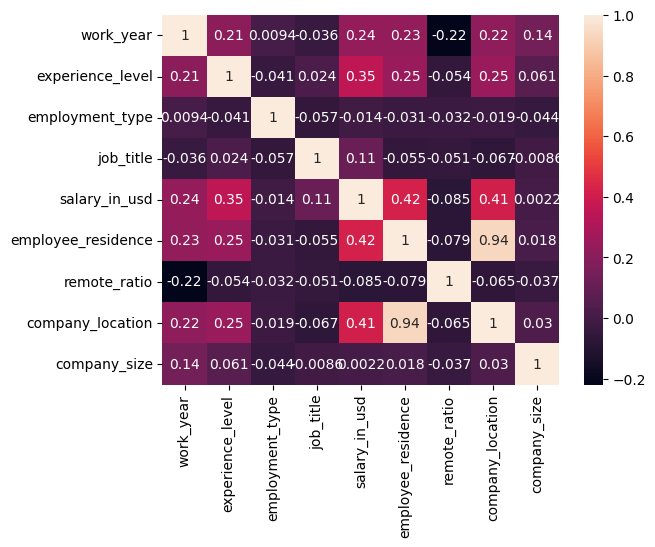

<Figure size 1500x1500 with 0 Axes>

In [18]:
sns.heatmap(df_salaries_clean.corr(), annot=True)
plt.figure(figsize=(15, 15))

In [19]:
pca = PCA()
pca.fit(df_salaries_clean)
print(pca.explained_variance_ratio_)

[9.99999247e-01 5.11536480e-07 1.50400355e-07 8.44979395e-08
 5.84703502e-09 1.82490880e-10 1.06908246e-10 4.38500523e-11
 5.68829654e-12]


select the top 5 features using SelectKBest with f regression


In [20]:

X = df_salaries_clean.drop(['salary_in_usd'], axis=1)
y = df_salaries_clean['salary_in_usd']
fs = SelectKBest(score_func=f_regression, k=5)
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)
X_selected

(2584, 5)


array([[2023,    3,   84,   26,   25],
       [2023,    2,   66,   75,   70],
       [2023,    2,   66,   75,   70],
       ...,
       [2020,    0,   47,   75,   70],
       [2020,    0,   17,   75,   70],
       [2021,    3,   45,   39,   38]], dtype=int64)

In [21]:
cols_idxs = fs.get_support(indices=True).tolist()
df_salaries_selected = df_salaries_clean.drop(
    ['salary_in_usd'], axis=1).iloc[:, cols_idxs]
df_salaries_selected['salary_in_usd'] = df_salaries_clean['salary_in_usd']
df_salaries_selected

,work_year,experience_level,job_title,employee_residence,company_location,salary_in_usd
0,2023,3,84,26,25,85847
1,2023,2,66,75,70,30000
2,2023,2,66,75,70,25500
3,2023,3,47,11,12,175000
4,2023,3,47,11,12,120000
...,...,...,...,...,...,...
2579,2020,3,47,75,70,412000
2580,2021,2,84,75,70,151000
2581,2020,0,47,75,70,105000
2582,2020,0,17,75,70,100000


save the dataset after pre-processed


In [22]:
df_salaries_selected.to_csv(
    '../0. Resources/datasets/data_salaries_preprocessed.csv', index=False)

### Credit Risk


In [23]:
df_credit_risk = pd.read_csv('../0. Resources/datasets/credit_risk.csv')
print(df_credit_risk.shape)
df_credit_risk.head(10)

(1000, 21)


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
5,no checking,36.0,existing paid,education,9055.0,no known savings,1<=X<4,2.0,male single,none,...,no known property,35.0,none,for free,1.0,unskilled resident,2.0,yes,yes,good
6,no checking,24.0,existing paid,furniture/equipment,2835.0,500<=X<1000,>=7,3.0,male single,none,...,life insurance,53.0,none,own,1.0,skilled,1.0,none,yes,good
7,0<=X<200,36.0,existing paid,used car,6948.0,<100,1<=X<4,2.0,male single,none,...,car,35.0,none,rent,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
8,no checking,12.0,existing paid,radio/tv,3059.0,>=1000,4<=X<7,2.0,male div/sep,none,...,real estate,61.0,none,own,1.0,unskilled resident,1.0,none,yes,good
9,0<=X<200,30.0,critical/other existing credit,new car,5234.0,<100,unemployed,4.0,male mar/wid,none,...,car,28.0,none,own,2.0,high qualif/self emp/mgmt,1.0,none,yes,bad


#### explore data


In [24]:
df_credit_risk.nunique()

checking_status             4
duration                   33
credit_history              5
purpose                    10
credit_amount             921
savings_status              5
employment                  5
installment_commitment      4
personal_status             4
other_parties               3
residence_since             4
property_magnitude          4
age                        53
other_payment_plans         3
housing                     3
existing_credits            4
job                         4
num_dependents              2
own_telephone               2
foreign_worker              2
class                       2
dtype: int64

In [25]:
df_credit_risk.dtypes

checking_status            object
duration                  float64
credit_history             object
purpose                    object
credit_amount             float64
savings_status             object
employment                 object
installment_commitment    float64
personal_status            object
other_parties              object
residence_since           float64
property_magnitude         object
age                       float64
other_payment_plans        object
housing                    object
existing_credits          float64
job                        object
num_dependents            float64
own_telephone              object
foreign_worker             object
class                      object
dtype: object

In [26]:
df_credit_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [27]:
df_credit_risk.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [28]:
numerical_cols = ['duration', 'credit_amount', 'installment_commitment',
                  'residence_since', 'age', 'existing_credits', 'num_dependents']
print(f'mean:\n{df_credit_risk[numerical_cols].mean()}\n')
print(f'std:\n{df_credit_risk[numerical_cols].std()}')

mean:
duration                    20.903
credit_amount             3271.258
installment_commitment       2.973
residence_since              2.845
age                         35.546
existing_credits             1.407
num_dependents               1.155
dtype: float64

std:
duration                    12.058814
credit_amount             2822.736876
installment_commitment       1.118715
residence_since              1.103718
age                         11.375469
existing_credits             0.577654
num_dependents               0.362086
dtype: float64


In [29]:
df_credit_risk['class'].value_counts()

class
good    700
bad     300
Name: count, dtype: int64

#### data visualization


[Text(0.5, 1.0, 'Distribution of Target Variable (class)')]

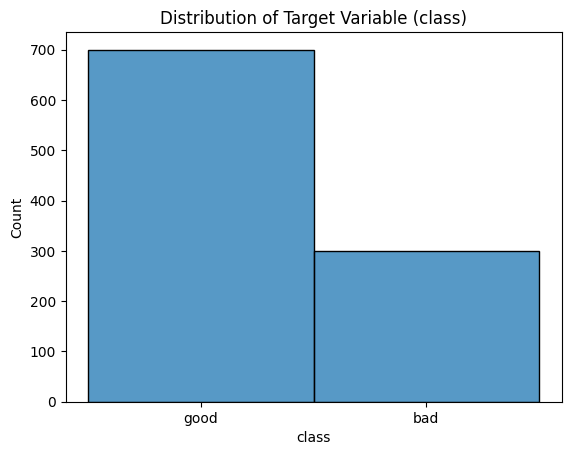

In [30]:
ax = sns.histplot(data=df_credit_risk, x='class')
ax.set(title='Distribution of Target Variable (class)')

[Text(0.5, 1.0, 'Distribution of Age')]

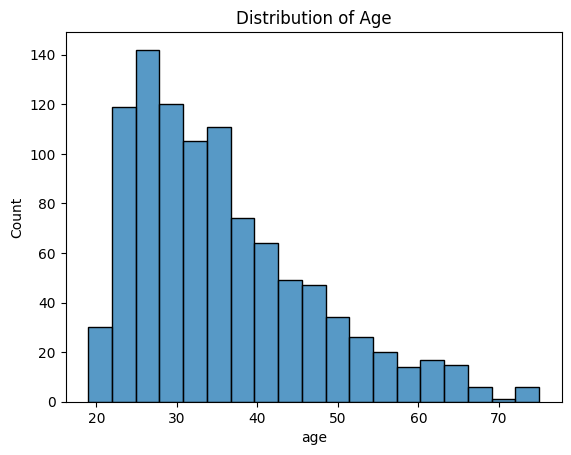

In [31]:
ax = sns.histplot(data=df_credit_risk, x='age')
ax.set(title='Distribution of Age')

[Text(0, 0.5, 'num_people'), Text(0.5, 1.0, 'Number of people by Job Level')]

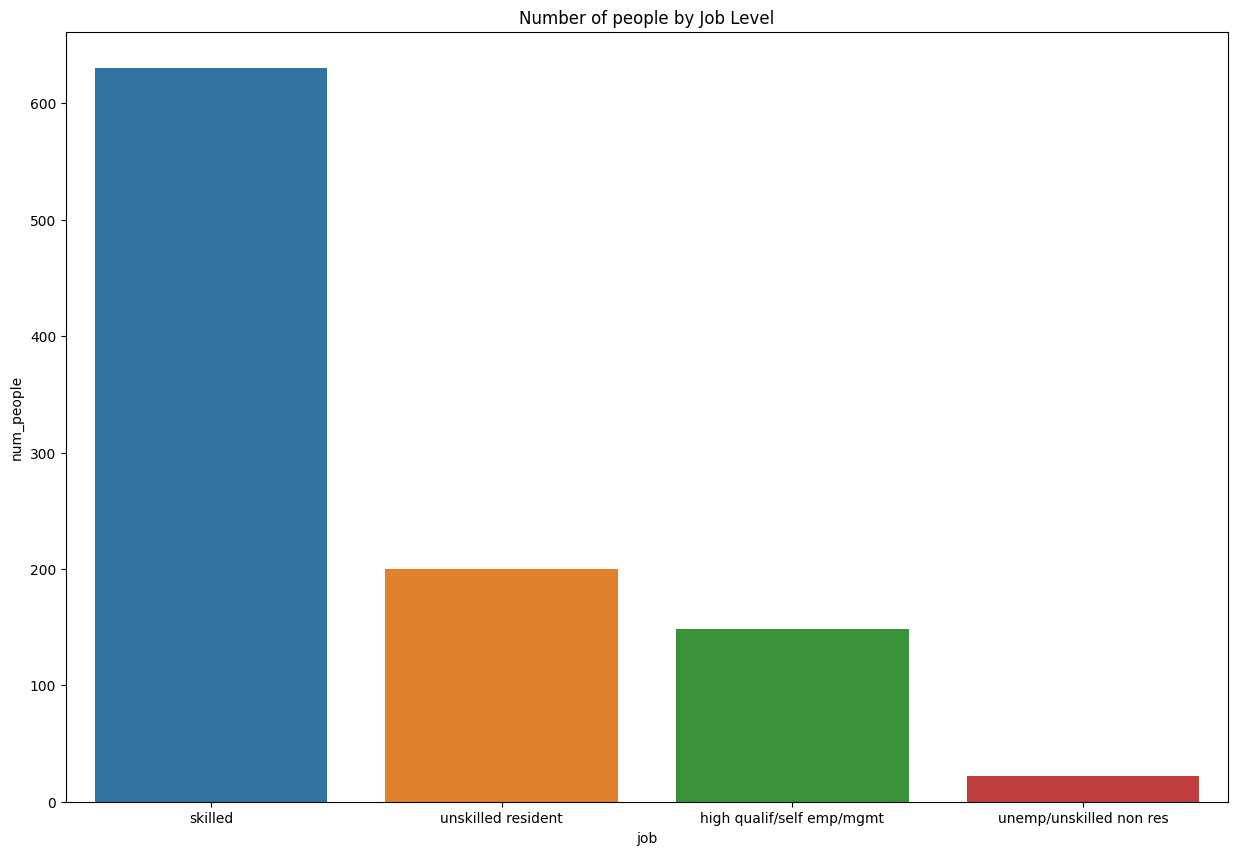

In [32]:
plt.figure(figsize=(15, 10))
jobs_counts = df_credit_risk['job'].value_counts()
ax = sns.barplot(data=df_credit_risk, x=jobs_counts.index,
                 y=jobs_counts.values)
ax.set(ylabel='num_people', title='Number of people by Job Level')

#### clean data


##### check missing values


no missing values found


In [33]:
df_credit_risk.isnull().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

##### check duplicated values


no duplicated values found


In [34]:
df_credit_risk.duplicated().sum()

0

##### outliers


<Axes: >

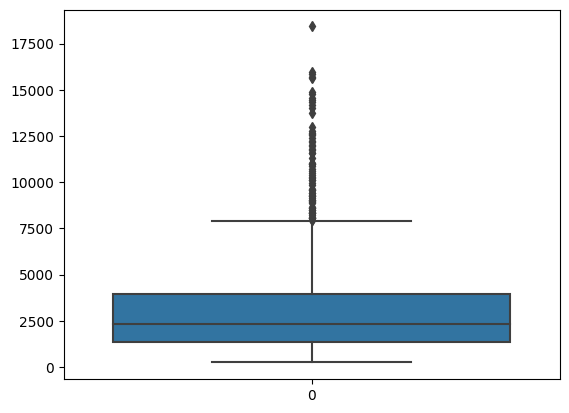

In [35]:
sns.boxplot(df_credit_risk['credit_amount'])

From the above graph and I also used the iqr to detect the outliers of the credit amount, and I found that there is outlier in the credit amount. I have remove the outliers since for the person that has the credit amount that is extremely higher than others, their credit reputation should be good and the bank should be easy to loan there money. Therefore, I just drop the outliers of the credit amount.


In [36]:
credit_outliers = iqr_outliers(df_credit_risk, 'credit_amount')
credit_outliers

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
5,no checking,36.0,existing paid,education,9055.0,no known savings,1<=X<4,2.0,male single,none,...,no known property,35.0,none,for free,1.0,unskilled resident,2.0,yes,yes,good
17,<0,30.0,no credits/all paid,business,8072.0,no known savings,<1,2.0,male single,none,...,car,25.0,bank,own,3.0,skilled,1.0,none,yes,good
18,0<=X<200,24.0,existing paid,used car,12579.0,<100,>=7,4.0,female div/dep/mar,none,...,no known property,44.0,none,for free,1.0,high qualif/self emp/mgmt,1.0,yes,yes,bad
57,no checking,36.0,critical/other existing credit,radio/tv,9566.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,car,31.0,stores,own,2.0,skilled,1.0,none,yes,good
63,0<=X<200,48.0,no credits/all paid,business,14421.0,<100,1<=X<4,2.0,male single,none,...,car,25.0,none,own,1.0,skilled,1.0,yes,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,<0,48.0,existing paid,used car,10297.0,<100,4<=X<7,4.0,male single,none,...,no known property,39.0,stores,for free,3.0,skilled,2.0,yes,yes,bad
945,0<=X<200,48.0,no credits/all paid,new car,8358.0,500<=X<1000,<1,1.0,female div/dep/mar,none,...,car,30.0,none,own,2.0,skilled,1.0,none,yes,good
953,no checking,36.0,existing paid,furniture/equipment,10974.0,<100,unemployed,4.0,female div/dep/mar,none,...,car,26.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes,bad
980,0<=X<200,30.0,critical/other existing credit,furniture/equipment,8386.0,<100,4<=X<7,2.0,male single,none,...,life insurance,49.0,none,own,1.0,skilled,1.0,none,yes,bad


In [37]:
df_credit_risk_cleaned = df_credit_risk.drop(
    credit_outliers.index).reset_index(drop=True)
df_credit_risk_cleaned

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,...,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes,good
924,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,...,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
925,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,...,car,38.0,none,own,1.0,skilled,1.0,none,yes,good
926,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,...,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes,bad


In [38]:
df_credit_risk_cleaned.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [39]:
df_credit_risk_cleaned['installment_commitment'].value_counts()

installment_commitment
4.0    461
2.0    200
3.0    150
1.0    117
Name: count, dtype: int64

##### format data type


In [40]:
df_credit_risk_cleaned.dtypes

checking_status            object
duration                  float64
credit_history             object
purpose                    object
credit_amount             float64
savings_status             object
employment                 object
installment_commitment    float64
personal_status            object
other_parties              object
residence_since           float64
property_magnitude         object
age                       float64
other_payment_plans        object
housing                    object
existing_credits          float64
job                        object
num_dependents            float64
own_telephone              object
foreign_worker             object
class                      object
dtype: object

In [41]:
cols_to_int = ['age', 'credit_amount', 'duration']
for i in cols_to_int:
    df_credit_risk_cleaned[i] = df_credit_risk_cleaned[i].astype('int64')
cols_to_cate = ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'installment_commitment',
                'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents']
for i in cols_to_cate:
    df_credit_risk_cleaned[i] = df_credit_risk_cleaned[i].astype('category')
df_credit_risk_cleaned[cols_to_cate] = df_credit_risk_cleaned[cols_to_cate].apply(
    le.fit_transform)
cols_object = ['own_telephone', 'foreign_worker', 'class']
# df_credit_risk_cleaned[cols_object] = df_credit_risk_cleaned[cols_object].apply(le.fit_transform)
for col in cols_object:
    df_credit_risk_cleaned[col] = df_credit_risk_cleaned[col].astype(
        'category').cat.codes

In [42]:
df_credit_risk_cleaned

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,1,6,1,6,1169,4,3,3,3,2,...,3,67,1,1,1,1,0,1,1,1
1,0,48,3,6,5951,2,0,1,0,2,...,3,22,1,1,0,1,0,0,1,0
2,3,12,1,2,2096,2,1,1,3,2,...,3,49,1,1,0,3,1,0,1,1
3,1,42,3,3,7882,2,1,1,3,1,...,1,45,1,0,0,1,1,0,1,1
4,1,24,2,4,4870,2,0,2,3,2,...,2,53,1,0,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,3,12,3,3,1736,2,1,2,0,2,...,3,31,1,1,0,3,0,0,1,1
924,1,30,3,9,3857,2,0,3,1,2,...,1,40,1,1,0,0,0,1,1,1
925,3,12,3,6,804,2,3,3,3,2,...,0,38,1,1,0,1,0,0,1,1
926,1,45,3,6,1845,2,0,3,3,2,...,2,23,1,0,0,1,0,1,1,0


##### imbalanced data


In [43]:
cols = df_credit_risk_cleaned.columns.to_list()
print(cols)
for i in cols:
    print(df_credit_risk_cleaned[i].value_counts())

['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'class']
checking_status
3    369
1    258
0    238
2     63
Name: count, dtype: int64
duration
12    179
24    178
18    111
6      73
15     64
36     60
9      49
30     36
48     33
21     29
10     28
27     11
42     10
11      9
20      8
8       7
60      6
4       6
7       5
45      4
13      4
28      3
14      3
33      3
39      2
16      2
22      2
5       1
72      1
40      1
Name: count, dtype: int64
credit_history
3    497
1    279
2     75
0     46
4     31
Name: count, dtype: int64
purpose
6    273
4    217
3    176
0     86
9     82
2     45
7     21
1     12
8      9
5      7
Name: count, dtype: int64
credit_amount
1478    3
1262    3


[Text(0.5, 1.0, 'Distribution of foreign worker')]

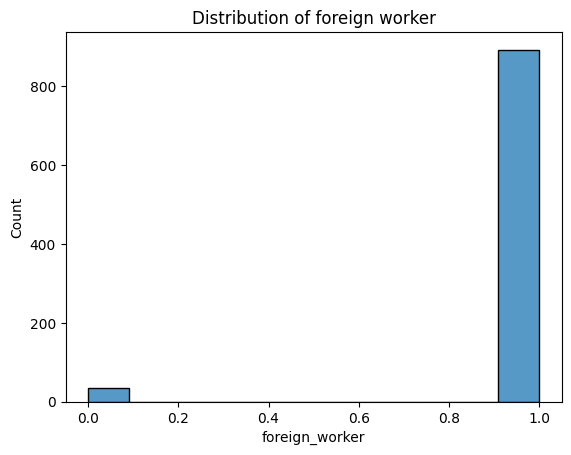

In [44]:
ax = sns.histplot(data=df_credit_risk_cleaned, x='foreign_worker')
ax.set(title='Distribution of foreign worker')

As we can see from the graph above, there is a skewed distribution of the foreign worker. In this case, the majority of the worker are foreign worker. Just drop the attribute.


In [45]:
df_credit_risk_reduced = df_credit_risk_cleaned[df_credit_risk_cleaned['foreign_worker'] == 1]
df_credit_risk_reduced = df_credit_risk_reduced.reset_index(drop=True)
df_credit_risk_reduced.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,1,6,1,6,1169,4,3,3,3,2,...,3,67,1,1,1,1,0,1,1,1
1,0,48,3,6,5951,2,0,1,0,2,...,3,22,1,1,0,1,0,0,1,0
2,3,12,1,2,2096,2,1,1,3,2,...,3,49,1,1,0,3,1,0,1,1
3,1,42,3,3,7882,2,1,1,3,1,...,1,45,1,0,0,1,1,0,1,1
4,1,24,2,4,4870,2,0,2,3,2,...,2,53,1,0,1,1,1,0,1,0


since I remove the non foreign worker, the foreign work only contains the 'yes' value, so I could remove this attribute.


In [46]:
df_credit_risk_reduced = df_credit_risk_reduced.drop(
    columns=['foreign_worker'])
df_credit_risk_reduced

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,class
0,1,6,1,6,1169,4,3,3,3,2,4.0,3,67,1,1,1,1,0,1,1
1,0,48,3,6,5951,2,0,1,0,2,2.0,3,22,1,1,0,1,0,0,0
2,3,12,1,2,2096,2,1,1,3,2,3.0,3,49,1,1,0,3,1,0,1
3,1,42,3,3,7882,2,1,1,3,1,4.0,1,45,1,0,0,1,1,0,1
4,1,24,2,4,4870,2,0,2,3,2,4.0,2,53,1,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,3,12,3,3,1736,2,1,2,0,2,4.0,3,31,1,1,0,3,0,0,1
889,1,30,3,9,3857,2,0,3,1,2,4.0,1,40,1,1,0,0,0,1,1
890,3,12,3,6,804,2,3,3,3,2,4.0,0,38,1,1,0,1,0,0,1
891,1,45,3,6,1845,2,0,3,3,2,4.0,2,23,1,0,0,1,0,1,0


[Text(0.5, 1.0, 'Distribution of Target Variable (class)')]

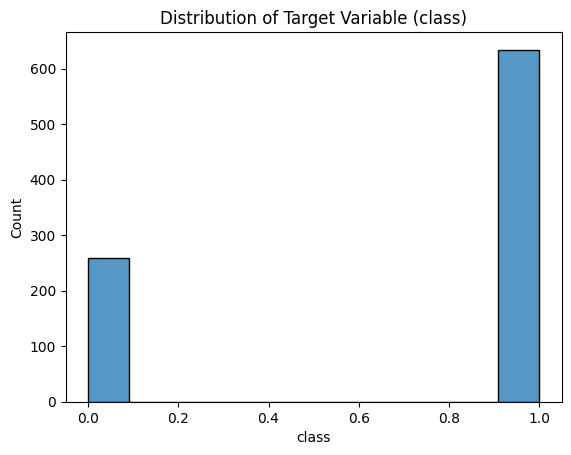

In [47]:
ax = sns.histplot(data=df_credit_risk_reduced, x='class')
ax.set(title='Distribution of Target Variable (class)')

In [48]:
class_distribution = df_credit_risk_reduced['class'].value_counts()

class_distribution

class
1    634
0    259
Name: count, dtype: int64

From the results we can see that our dataset is skewed, 667 records of the data is 1(good) and 2643 records is 0(bad). This is normal because not too many people has bad result for credit check
We could use two strategies: under-sampling and over-sampling. Under-sampling aims to balance the dataset by reducing the size of the abundance class. When there is enough data available, this method is used. Oversampling, on the other hand, is used when there is insufficient data. As a result, rare samples are increased in size to balance the dataset. However, over-sampling may cause the other issues because this may introduce the noise to the dataset. It would can be reduced if we use the K-fold cross validation to avoid it and overfitting issue.
To get a normal distribution we need to either reduce or boost the dataset. We decided to boost our dataset to the equal distribution by using the Synthetic Minority Oversampling Technique (SMOTE). However, as I said this may cause the other issues because this may introduce the noise to the dataset.
Since the class is the target of my study, I will set the class as the y value and the rest of the data will be my x value. Using the x value to predict y. From the following the size of x and y has been stated.


In [49]:

X = df_credit_risk_reduced.drop(['class'], axis=1)
y = df_credit_risk_reduced['class']
print(X.shape, y.shape)

(893, 19) (893,)


In [50]:
print(f'Before SMOTE, count of Label 1: {sum(y==1)}')
print(f'Before SMOTE, count of Label 1: {sum(y==0)}')
oversample = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = oversample.fit_resample(X, y)
print(f'After SMOTE, shape of the data X:y{X_res.shape}, {y_res.shape}')
print(f'After SMOTE, count of Label 1: {sum(y_res==1)}')
print(f'After SMOTE, count of Label 1: {sum(y_res==0)}')

Before SMOTE, count of Label 1: 634
Before SMOTE, count of Label 1: 259
After SMOTE, shape of the data X:y(1268, 19), (1268,)
After SMOTE, count of Label 1: 634
After SMOTE, count of Label 1: 634


##### identify correlation


Text(0.5, 1.0, 'Features Correlating with Sales Price')

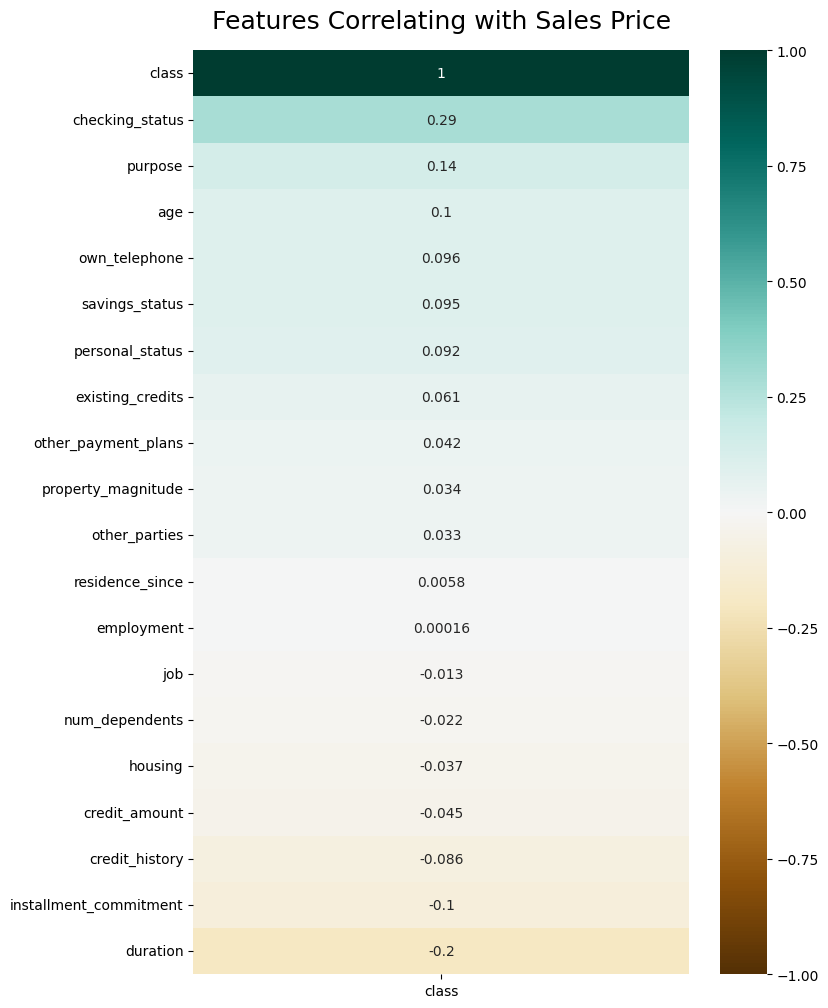

In [51]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_credit_risk_reduced.corr()[['class']].sort_values(
    by='class', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price',
                  fontdict={'fontsize': 18}, pad=16)

<Figure size 20000x20000 with 0 Axes>

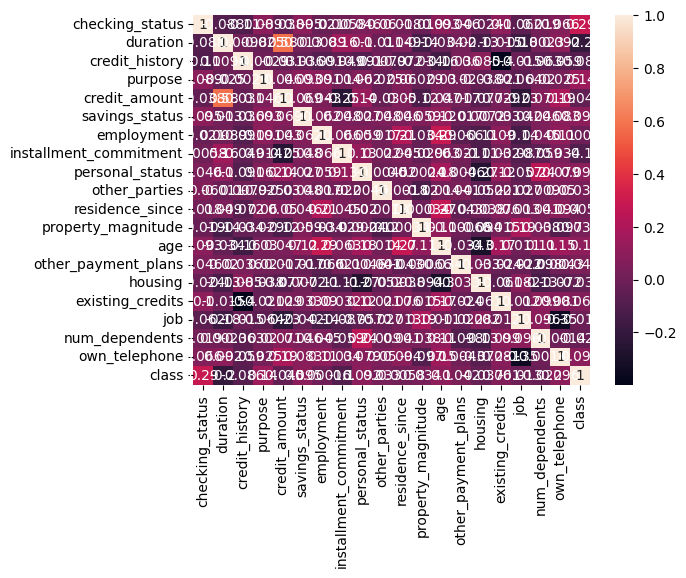

<Figure size 20000x20000 with 0 Axes>

In [52]:
sns.heatmap(df_credit_risk_reduced.corr(), annot=True)
plt.figure(figsize=(200, 200))

##### select k best features


In [53]:
fs = SelectKBest(score_func=f_regression, k=10)
X_selected = fs.fit_transform(X_res, y_res)
print(X_selected.shape)
X_selected

(1268, 10)


array([[ 1.,  6.,  6., ...,  1.,  1.,  1.],
       [ 0., 48.,  6., ...,  1.,  0.,  0.],
       [ 3., 12.,  2., ...,  1.,  0.,  0.],
       ...,
       [ 1., 12.,  4., ...,  1.,  0.,  0.],
       [ 1., 25.,  5., ...,  1.,  0.,  0.],
       [ 0.,  9.,  5., ...,  0.,  0.,  0.]])

In [54]:
selected_cols = X.columns[fs.get_support()].tolist()
selected_cols

['checking_status',
 'duration',
 'purpose',
 'savings_status',
 'personal_status',
 'property_magnitude',
 'age',
 'other_payment_plans',
 'existing_credits',
 'own_telephone']

In [55]:
df_credit_risk_resampled = pd.DataFrame(X_selected, columns=selected_cols)
df_credit_risk_resampled['class'] = y_res
df_credit_risk_resampled.head()

,checking_status,duration,purpose,savings_status,personal_status,property_magnitude,age,other_payment_plans,existing_credits,own_telephone,class
0,1.0,6.0,6.0,4.0,3.0,3.0,67.0,1.0,1.0,1.0,1
1,0.0,48.0,6.0,2.0,0.0,3.0,22.0,1.0,0.0,0.0,0
2,3.0,12.0,2.0,2.0,3.0,3.0,49.0,1.0,0.0,0.0,1
3,1.0,42.0,3.0,2.0,3.0,1.0,45.0,1.0,0.0,0.0,1
4,1.0,24.0,4.0,2.0,3.0,2.0,53.0,1.0,1.0,0.0,0


##### save file


In [56]:
df_credit_risk_resampled.to_csv(
    '../0. Resources/datasets/data_credit_risk_preprocessed.csv', index=False)